## Overview
Data preparation: 

- [x] Data cleaning 
- [x] Feature selection 
- [x] Feature engineering 
- [x] Feature encoding 
- [x] Prefix extraction 
- [ ] Optional: Prefix bucketing 
- [x] Prefix encoding 

In [ ]:
pip install pm4py

In [ ]:
import pandas as pd
import pm4py

## Reading data

In [ ]:
# The international declarations event log
file_path = "/content/drive/MyDrive/Tue/Advanced PM/APM project/data/InternationalDeclarations.xes.gz"
event_log = pm4py.read_xes(file_path) 

NameError: ignored

In [ ]:
event_log.columns

## Data exploration

In [ ]:
num_events = len(event_log)
num_cases = len(event_log['case:id'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

Number of events: 72151
Number of cases: 6449


Let's see the distribution of number of events per case in the histogram below.

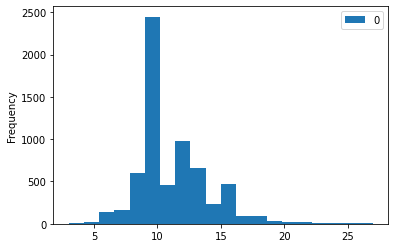

In [ ]:
events_per_case = event_log.groupby('case:id').size().reset_index()
events_per_case.plot.hist(bins=20)

let's see the actual numbers in a table below

In [ ]:
events_per_case.rename(columns={0: 'trace_length'}).groupby('trace_length').size()

trace_length
3       10
5       16
6      142
7      161
8      600
9      208
10    2239
11     462
12     974
13     654
14     230
15     319
16     152
17      90
18      88
19      38
20      19
21      13
22      10
23      10
24       5
25       5
26       1
27       3
dtype: int64

Let's see now the start and end activities

In [ ]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Permit SUBMITTED by EMPLOYEE': 5294, 'Start trip': 740, 'Declaration SUBMITTED by EMPLOYEE': 407, 'Declaration SAVED by EMPLOYEE': 8}
End activities: {'Payment Handled': 5646, 'End trip': 593, 'Declaration REJECTED by EMPLOYEE': 130, 'Declaration SAVED by EMPLOYEE': 54, 'Declaration REJECTED by MISSING': 11, 'Permit REJECTED by MISSING': 8, 'Request Payment': 3, 'Send Reminder': 2, 'Declaration FINAL_APPROVED by SUPERVISOR': 1, 'Declaration REJECTED by SUPERVISOR': 1}


Let's see the minimum and maximum timestamps in the log.

In [ ]:
print('min: ', event_log['time:timestamp'].min())
print('max: ', event_log['time:timestamp'].max())

min:  2016-10-04 22:00:00+00:00
max:  2020-05-09 22:00:00+00:00


In [ ]:
pm4py.view_dotted_chart(event_log)

## Data cleaning

### Filtering out cases before 2018.

We know from the process description that the process changed in 2018 to incorporate more departments. So we are going to keep only the traces from 2018 on.

In [ ]:
filtered_log = event_log[event_log['time:timestamp'] >= '2018-01-01 00:00:00']
print('min: ', filtered_log['time:timestamp'].min())
print('max: ', filtered_log['time:timestamp'].max())
num_cases_filtered = len(filtered_log['case:id'].unique())
print("num cases: {}\nRemoved cases: {} ({}%)".format(num_cases_filtered,
                                                     num_cases - num_cases_filtered,
                                                     round((num_cases - num_cases_filtered)/num_cases, 4) * 100))

min:  2018-01-01 23:00:00+00:00
max:  2020-05-09 22:00:00+00:00
num cases: 5322
Removed cases: 1127 (17.48%)


### Filtering traces with activity "Payment Handled"

Since we are interested in finding the time from "declaration submitted" to "payment handled", we are going to filter only the traces that contain the activity "payment handled".

In [ ]:
filtered_log = pm4py.filter_event_attribute_values(filtered_log, 'concept:name', {'Payment Handled'})
num_cases = num_cases_filtered
num_cases_filtered = len(filtered_log['case:id'].unique())
print("num cases: {}\nRemoved cases: {} ({}%)".format(num_cases_filtered,
                                                     num_cases - num_cases_filtered,
                                                     round((num_cases - num_cases_filtered)/num_cases, 4) * 100))

num cases: 4924
Removed cases: 398 (7.48%)


Let's see the start and end activities again

In [ ]:
start_activities = pm4py.get_start_activities(filtered_log)
end_activities = pm4py.get_end_activities(filtered_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Permit SUBMITTED by EMPLOYEE': 4074, 'Start trip': 532, 'Declaration SUBMITTED by EMPLOYEE': 270, 'Payment Handled': 16, 'Request Payment': 10, 'Send Reminder': 7, 'End trip': 6, 'Declaration APPROVED by ADMINISTRATION': 4, 'Permit REJECTED by EMPLOYEE': 3, 'Declaration REJECTED by ADMINISTRATION': 1, 'Declaration REJECTED by EMPLOYEE': 1}
End activities: {'Payment Handled': 4578, 'End trip': 341, 'Request Payment': 3, 'Send Reminder': 2}


We can still see that for 3 cases a payment request was sent even after one payment had already been handled. In 2 cases a reminder was sent after one payment had been handled. In theses cases the end activities could be referring to a different declaration submission, which leads us to think that in some cases not all declarations led to a payment, some remained unhandled.

### Filtering out non-frequent variants




In our analysis we don't want to consider all possible variants in the event log because some variants are too unique, which represents a non-frequent behaviour. We want to be able to generalize our prediction and that's why we are going to cut off the variants with less than 10 occurrences. Based on the histogram we saw previously, we think that 10 is a good threshold to eliminate non-frequent variants.

In [ ]:
# Get all variants in the event log
variants = pm4py.get_variants(filtered_log, activity_key='concept:name', case_id_key='case:id', timestamp_key='time:timestamp')
print(len(variants), "variants in total")

493 variants in total


In [ ]:
variants_at_least_10 = {key: value for (key, value) in variants.items() if value >= 10 }
print(len(variants_at_least_10), "variants with less than 10 ocurrences")

57 variants with less than 10 ocurrences


In [ ]:
filtered_log = pm4py.filter_variants(filtered_log,
                                     variants_at_least_10.keys(),
                                     activity_key='concept:name',
                                     case_id_key='case:id',
                                     timestamp_key='time:timestamp')

num_cases = num_cases_filtered
num_cases_filtered = len(filtered_log['case:id'].unique())
print("num cases: {}\nRemoved cases: {} ({}%)".format(num_cases_filtered,
                                                     num_cases - num_cases_filtered,
                                                     round((num_cases - num_cases_filtered)/num_cases, 4) * 100))

num cases: 4118
Removed cases: 806 (16.37%)


So, around 16% of the traces were removed. Let's see the trace length histogram again.

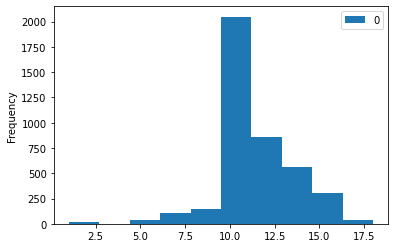

In [ ]:
filtered_log.groupby('case:id').size().reset_index().plot.hist()

If we check again the start and end activities, we see that the problematic end activities were removed.

In [ ]:
start_activities = pm4py.get_start_activities(filtered_log)
end_activities = pm4py.get_end_activities(filtered_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Permit SUBMITTED by EMPLOYEE': 3515, 'Start trip': 364, 'Declaration SUBMITTED by EMPLOYEE': 223, 'Payment Handled': 16}
End activities: {'Payment Handled': 3864, 'End trip': 254}


## Modeling

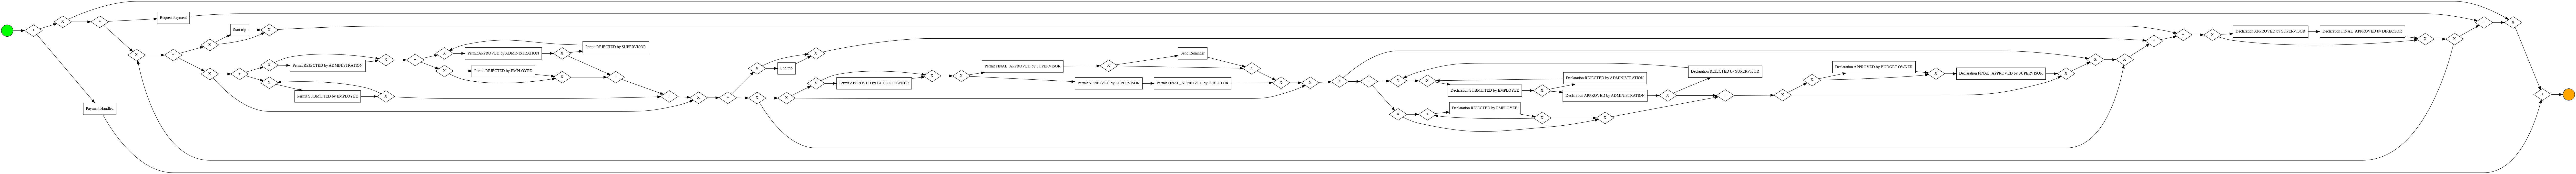

In [ ]:
bpmn_graph = pm4py.discover_bpmn_inductive(filtered_log,
                                           noise_threshold=0,
                                           activity_key='concept:name',
                                           case_id_key='case:id',
                                           timestamp_key='time:timestamp')
pm4py.view_bpmn(bpmn_graph)

The model needs to be reshaped we can see for example that this model allows the process to start with a payment request, which should not be possible in real life.

## Feature Selection and Engineering

### Dropping irrelevant columns

In [ ]:
dataframe = pm4py.convert_to_dataframe(filtered_log)
dataframe.head()

,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
189,st_step 73629_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-01-12 11:38:18+00:00,EMPLOYEE,travel permit number 73563,declaration number 73583,199.54626,199.54626,task 427,...,declaration 73582,organizational unit 65455,travel permit number 73563,6020.792331,declaration 73582,travel permit 73562,travel permit 73562,budget 143495,UNKNOWN,199.54626
190,st_step 73628_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-01-12 11:38:24+00:00,ADMINISTRATION,travel permit number 73563,declaration number 73583,199.54626,199.54626,task 427,...,declaration 73582,organizational unit 65455,travel permit number 73563,6020.792331,declaration 73582,travel permit 73562,travel permit 73562,budget 143495,UNKNOWN,199.54626
191,st_step 73630_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-15 10:58:19+00:00,SUPERVISOR,travel permit number 73563,declaration number 73583,199.54626,199.54626,task 427,...,declaration 73582,organizational unit 65455,travel permit number 73563,6020.792331,declaration 73582,travel permit 73562,travel permit 73562,budget 143495,UNKNOWN,199.54626
192,fd_declaration 73582_17,SYSTEM,Request Payment,2018-01-23 07:43:55+00:00,UNDEFINED,travel permit number 73563,declaration number 73583,199.54626,199.54626,task 427,...,declaration 73582,organizational unit 65455,travel permit number 73563,6020.792331,declaration 73582,travel permit 73562,travel permit 73562,budget 143495,UNKNOWN,199.54626
193,fd_declaration 73582_18,SYSTEM,Payment Handled,2018-01-25 16:31:08+00:00,UNDEFINED,travel permit number 73563,declaration number 73583,199.54626,199.54626,task 427,...,declaration 73582,organizational unit 65455,travel permit number 73563,6020.792331,declaration 73582,travel permit 73562,travel permit 73562,budget 143495,UNKNOWN,199.54626


First, we are going to remove all columns that are obviously not good predictors like ID columns. 

We also checked that 'case:OriginalAmount', 'case:RequestedAmount', 'case:AdjustedAmount' and 'case:Amount' have always the same value, so we are going to keep only 'case:Amount'.

In [ ]:
dataframe = dataframe.drop(columns=['id', 'org:resource', 'case:Permit travel permit number', 'case:DeclarationNumber',
                                 'case:concept:name', 'case:travel permit number', 'case:Permit ID', 'case:Permit id',
                                  'case:OriginalAmount', 'case:RequestedAmount', 'case:AdjustedAmount'])
dataframe.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit TaskNumber,case:Permit BudgetNumber,case:Permit ProjectNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:Permit ActivityNumber
189,Declaration SUBMITTED by EMPLOYEE,2018-01-12 11:38:18+00:00,EMPLOYEE,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,UNKNOWN
190,Declaration APPROVED by ADMINISTRATION,2018-01-12 11:38:24+00:00,ADMINISTRATION,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,UNKNOWN
191,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-15 10:58:19+00:00,SUPERVISOR,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,UNKNOWN
192,Request Payment,2018-01-23 07:43:55+00:00,UNDEFINED,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,UNKNOWN
193,Payment Handled,2018-01-25 16:31:08+00:00,UNDEFINED,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,UNKNOWN


### Replacing "UNKNOWN" with NA

The columns that contain "UNKNOWN" are 'case:Permit TaskNumber', 'case:Permit ProjectNumber' and 'case:Permit ActivityNumber'

In [ ]:
dataframe.replace('UNKNOWN', pd.NA, inplace=True)
dataframe.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit TaskNumber,case:Permit BudgetNumber,case:Permit ProjectNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:Permit ActivityNumber
189,Declaration SUBMITTED by EMPLOYEE,2018-01-12 11:38:18+00:00,EMPLOYEE,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,<NA>
190,Declaration APPROVED by ADMINISTRATION,2018-01-12 11:38:24+00:00,ADMINISTRATION,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,<NA>
191,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-15 10:58:19+00:00,SUPERVISOR,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,<NA>
192,Request Payment,2018-01-23 07:43:55+00:00,UNDEFINED,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,<NA>
193,Payment Handled,2018-01-25 16:31:08+00:00,UNDEFINED,199.54626,task 427,budget 899,project 8761,organizational unit 65455,6020.792331,declaration 73582,budget 143495,<NA>


### Dropping columns with too many NAs

In [ ]:
len(dataframe)

46011

In [ ]:
dataframe.isna().sum()

concept:name                            0
time:timestamp                          0
org:role                                0
case:Amount                             0
case:Permit TaskNumber              17557
case:Permit BudgetNumber                0
case:Permit ProjectNumber           17512
case:Permit OrganizationalEntity        0
case:Permit RequestedBudget             0
case:id                                 0
case:BudgetNumber                      20
case:Permit ActivityNumber          42969
dtype: int64

The following columns will be dropped because they have a lot of missing values.

*   case:Permit ActivityNumber (94% missing values)
*   case:Permit TaskNumber (38% missing values)
*   case:Permit ProjectNumber (38% missing values)



In [ ]:
dataframe = dataframe.drop(columns=['case:Permit ActivityNumber', 'case:Permit TaskNumber', 'case:Permit ProjectNumber'])

### Disentangle the resource name from the activity name

The resource information is already present in the 'org:role' column. We want this information separated from the activity (concept:name).

In [ ]:
dataframe['concept:name'] = dataframe['concept:name'].str.split(' by').str[0]
dataframe.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber
189,Declaration SUBMITTED,2018-01-12 11:38:18+00:00,EMPLOYEE,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495
190,Declaration APPROVED,2018-01-12 11:38:24+00:00,ADMINISTRATION,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495
191,Declaration FINAL_APPROVED,2018-01-15 10:58:19+00:00,SUPERVISOR,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495
192,Request Payment,2018-01-23 07:43:55+00:00,UNDEFINED,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495
193,Payment Handled,2018-01-25 16:31:08+00:00,UNDEFINED,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495


### Transform "Start Trip" and "End Trip" into case attributes

The activities "Start Trip" and "End Trip" are not actually activities of the process. We think they they should be treated as case attributes since they represent information about the case but not actually an activity performed inside the process of International Trips Declaration. 

We are going to remove those activites from the column "concept:name" and include the variables "case:TripDuration" and "case:TripMonth" as case attributes.

In [ ]:
# Filtering only start trip and end trip
trip_info_df = dataframe[dataframe['concept:name'].isin(['Start trip', 'End trip'])][['case:id', 'concept:name', 'time:timestamp']]

# reshaping the dataframe from long to wide
trip_info_df = trip_info_df.pivot(index='case:id', columns='concept:name', values='time:timestamp').reset_index()

#computing trip duration and trip start month
trip_info_df['case:TripDuration'] = trip_info_df['End trip'] - trip_info_df['Start trip']
trip_info_df['case:TripStartMonth'] = trip_info_df['Start trip'].dt.month.astype(str)
trip_info_df['case:TripEndMonth'] = trip_info_df['End trip'].dt.month.astype(str)

# Selecting only the necessary columns
trip_info_df = trip_info_df[['case:id', 'case:TripDuration', 'case:TripStartMonth', 'case:TripEndMonth']]

# Filtering out start trip and end trip activities from the dataframe
dataframe = dataframe[~dataframe['concept:name'].isin(['Start trip', 'End trip'])]

# Merge new features with the dataframe
dataframe = dataframe.merge(trip_info_df, on='case:id', how='left')
dataframe.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth
0,Declaration SUBMITTED,2018-01-12 11:38:18+00:00,EMPLOYEE,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495,NaT,NaN,NaN
1,Declaration APPROVED,2018-01-12 11:38:24+00:00,ADMINISTRATION,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495,NaT,NaN,NaN
2,Declaration FINAL_APPROVED,2018-01-15 10:58:19+00:00,SUPERVISOR,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495,NaT,NaN,NaN
3,Request Payment,2018-01-23 07:43:55+00:00,UNDEFINED,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495,NaT,NaN,NaN
4,Payment Handled,2018-01-25 16:31:08+00:00,UNDEFINED,199.54626,budget 899,organizational unit 65455,6020.792331,declaration 73582,budget 143495,NaT,NaN,NaN


We can see that for some cases the trip duration is null. Probably because the trip started in 2017 and the process for the declaration started in 2018. Since we filtered all the information before 2018, the trip start and end were removed.

In [ ]:
dataframe.isna().sum()

concept:name                          0
time:timestamp                        0
org:role                              0
case:Amount                           0
case:Permit BudgetNumber              0
case:Permit OrganizationalEntity      0
case:Permit RequestedBudget           0
case:id                               0
case:BudgetNumber                    16
case:TripDuration                   676
case:TripStartMonth                 332
case:TripEndMonth                   332
dtype: int64

In [ ]:
len(dataframe)

37951

We are going to remove those cases since they represent only 1% of the data.

In [ ]:
dataframe.dropna(inplace=True)

### Create target variable

The target variable is the remaining time till "Payment Handled".

In [ ]:
# Get the "Payment Handled" timestamp for each case
payment_handled_df = dataframe[dataframe['concept:name'] == 'Payment Handled'][['case:id', 'time:timestamp']]
payment_handled_df.rename(columns={"time:timestamp": "time:PaymentHandled"}, inplace=True)

dataframe = dataframe.merge(payment_handled_df, on='case:id')

dataframe['time:Remaining'] = dataframe['time:PaymentHandled'] - dataframe['time:timestamp']
dataframe.drop(['time:PaymentHandled'], axis=1, inplace=True)
dataframe.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth,time:Remaining
0,Declaration SUBMITTED,2018-03-12 13:59:22+00:00,EMPLOYEE,527.004149,budget 635,organizational unit 65458,769.0131,declaration 76028,budget 145820,13 days,2.0,3,10 days 02:31:49
1,Declaration APPROVED,2018-03-15 10:04:28+00:00,ADMINISTRATION,527.004149,budget 635,organizational unit 65458,769.0131,declaration 76028,budget 145820,13 days,2.0,3,7 days 06:26:43
2,Declaration APPROVED,2018-03-15 13:21:30+00:00,BUDGET OWNER,527.004149,budget 635,organizational unit 65458,769.0131,declaration 76028,budget 145820,13 days,2.0,3,7 days 03:09:41
3,Declaration FINAL_APPROVED,2018-03-19 11:22:53+00:00,SUPERVISOR,527.004149,budget 635,organizational unit 65458,769.0131,declaration 76028,budget 145820,13 days,2.0,3,3 days 05:08:18
4,Request Payment,2018-03-21 08:34:37+00:00,UNDEFINED,527.004149,budget 635,organizational unit 65458,769.0131,declaration 76028,budget 145820,13 days,2.0,3,1 days 07:56:34


### Removing activities "Payment Handled"

Since we want to predict the time it takes to get to "Payment Handled", it doesn't make sense to predict that when we are at the "Payment Handled" activity.

In [ ]:
dataframe = dataframe[dataframe['concept:name'] != 'Payment Handled']

## Encoding

### Last State Encoding (prefix level)

Almost all the features we have are case attributes. The only modification we are going to perform for this enconding is to replace the timestamp with the relative time since the start of the case.

In [ ]:
last_state_df = dataframe.sort_values(['case:id', 'time:timestamp'])

last_state_df['time:start'] = last_state_df.groupby('case:id')['time:timestamp'].transform('first')
last_state_df['time:relative'] = last_state_df['time:timestamp'] - last_state_df['time:start']

last_state_df.drop(columns=['time:start'], inplace=True)

last_state_df.head()

,concept:name,time:timestamp,org:role,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth,time:Remaining,time:relative
8180,Permit SUBMITTED,2018-03-01 09:55:17+00:00,EMPLOYEE,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,39 days 05:35:41,0 days 00:00:00
8181,Permit APPROVED,2018-03-01 09:55:21+00:00,ADMINISTRATION,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,39 days 05:35:37,0 days 00:00:04
8182,Permit FINAL_APPROVED,2018-03-01 14:01:48+00:00,SUPERVISOR,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,39 days 01:29:10,0 days 04:06:31
8183,Declaration SUBMITTED,2018-03-27 14:15:02+00:00,EMPLOYEE,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,13 days 01:15:56,26 days 04:19:45
8184,Declaration APPROVED,2018-04-03 15:07:56+00:00,ADMINISTRATION,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,6 days 00:23:02,33 days 05:12:39


In [ ]:
# Confirming if case:Amount is unique for each case
x = last_state_df.groupby('case:id')['case:Amount'].nunique()
x[x > 1]

Series([], Name: case:Amount, dtype: int64)

### Aggregation Enconding (prefix level)

In [ ]:
# First, organizing the columns (first case attributes, then activities, resources, time and at last the target)
# TODO

# Generating 1 dummy column for each activity and resource
aggregation_df = pd.get_dummies(last_state_df,
                                columns=['concept:name', 'org:role'],
                                prefix={'concept:name': 'act', 'org:role': 'res'}
                                )

# Now compute the aggregation (cumulative sum) for each new feature
aggregation_df[aggregation_df.columns.drop(['case:Amount', 'time:timestamp',
                                            'case:Permit BudgetNumber',
                                            'case:Permit OrganizationalEntity',
                                            'case:Permit RequestedBudget',
                                            'case:id', 'case:BudgetNumber',
                                            'case:TripDuration', 'case:TripStartMonth',
                                            'case:TripEndMonth',
                                            'time:Remaining', 'time:relative']
                                           )] = (aggregation_df
                                                 .sort_values(['case:id', 'time:relative'])
                                                 .groupby(['case:id'])[aggregation_df.columns.drop(['case:Amount', 'time:timestamp',
                                                                                                    'case:Permit BudgetNumber',
                                                                                                    'case:Permit OrganizationalEntity',
                                                                                                    'case:Permit RequestedBudget',
                                                                                                    'case:id', 'case:BudgetNumber',
                                                                                                    'case:TripDuration', 'case:TripStartMonth',
                                                                                                    'case:TripEndMonth',
                                                                                                    'time:Remaining', 'time:relative'])]
                                                 .transform('cumsum')
                                                 )
                                           

aggregation_df.head()

,time:timestamp,case:Amount,case:Permit BudgetNumber,case:Permit OrganizationalEntity,case:Permit RequestedBudget,case:id,case:BudgetNumber,case:TripDuration,case:TripStartMonth,case:TripEndMonth,...,act_Permit REJECTED,act_Permit SUBMITTED,act_Request Payment,act_Send Reminder,res_ADMINISTRATION,res_BUDGET OWNER,res_DIRECTOR,res_EMPLOYEE,res_SUPERVISOR,res_UNDEFINED
8180,2018-03-01 09:55:17+00:00,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,...,0,1,0,0,0,0,0,1,0,0
8181,2018-03-01 09:55:21+00:00,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,...,0,1,0,0,1,0,0,1,0,0
8182,2018-03-01 14:01:48+00:00,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,...,0,1,0,0,1,0,0,1,1,0
8183,2018-03-27 14:15:02+00:00,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,...,0,1,0,0,1,0,0,2,1,0
8184,2018-04-03 15:07:56+00:00,361.39224,budget 994,organizational unit 65460,1273.252058,declaration 1002,budget 146827,4 days,3.0,3,...,0,1,0,0,2,0,0,2,1,0


## Writing results

In [ ]:
folder_path = '/content/drive/MyDrive/Tue/Advanced PM/APM project/phase 3/data/'
last_state_df.to_csv(folder_path + 'last_state_enconding.csv', index=False)
aggregation_df.to_csv(folder_path + 'aggregation_enconding.csv', index=False)